# Esercizio 4 - Segmentation

- Implementare un semplice algoritmo di text segmentation
- Usare come test un input di k paragrafi presi da differenti temi (ad es. pagine Wikipedia)  
- Il vostro sistema è in grado di trovare i giusti “tagli”?

## Idea:

- Ripulisco il file di testo da stopwords e punteggiatura e lo tokenizzo e lemmatizzo, ottenendo una lista di relevant words
- Suddivido il file di input in una lista di liste: ogni riga del file di input diventa una lista di relevant words
- Calcolo la cosine similarity tra ogni riga del file di input e la riga successiva
- Posiziono i tagli nei punti di minimo della cosine similarity


## File di input

Come file di input uso un file di testo contenente un po' di paragrafi presi da Wikipedia riguardo a 4 argomenti diversi:
- Lebanon
- Racing bike
- Labrador retriever
- Indie rock  

I tagli che dovrebbe trovare il mio algoritmo sono alla linea 27-28, alla linea 58-59 e alla linea 97-98.


In [32]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

### Preprocessing del file di input

In [33]:
data = []
with open('../data/wiki.txt', 'r') as f:
    for line in f:
        data.append(line.strip())
    
lemmatizer = WordNetLemmatizer()
tokenizer = RegexpTokenizer(r'\w+')
stop_words = stopwords.words('english')
preprocessed_data = []
for line in data:
    words = [lemmatizer.lemmatize(token.lower()) for token in tokenizer.tokenize(line) if token.lower() not in stop_words] 
    preprocessed_data.append(words)

# paragraphs[0]

### Creo una lista di tutte le relevant words del file di input, rimuovendo i duplicati ma mantenendo l'ordine 

In [34]:
# Create a list of all words with duplicates
all_words = []
for line in preprocessed_data:
    for word in line:
        all_words.append(word)

# Remove duplicates but keep the order
all_words = list(dict.fromkeys(all_words))
# all_words

# all_words = list(all_words)
# all_words_dict = {word: i for i, word in enumerate(all_words)}
# all_words_dict

# Convert preprocessed data to a list
doc = []
for line in preprocessed_data:
    for word in line:
        doc.append(word)

print(len(doc))
print(len(all_words))

5115
2160


### Creo un dizionario per ogni paragrafo del file di input, dove la chiave è la parola e il valore la sua frequenza

In [35]:
# Split the document (which is a list) by a given number of words
# Return a list of lists which is gonna be the list of paragraphs
def split_doc(document, n):
    return [document[i:i+n] for i in range(0, len(document), n)]

# Create a dictionary with keys = all words in a document, values = word counts in a paragraph
def paragraph_dict(paragraph, document):
    paragraph_dict = {}
    for word in document:
        paragraph_dict[word] = 0
    for word in paragraph:
        paragraph_dict[word] += 1
    return paragraph_dict

# From the dictionary create a list of word counts
def paragraph_list(paragraph_dict, document):
    paragraph_list = []
    for word in document:
        paragraph_list.append(paragraph_dict[word])
    return paragraph_list

# Get for all paragraphs (splitted by n words) a list of word counts
def get_paragraphs_list(document, n):
    paragraphs = split_doc(document, n)
    paragraphs_list = []
    for paragraph in paragraphs:
        paragraphs_list.append(paragraph_list(paragraph_dict(paragraph, document), document))
    return paragraphs_list


### Calcolo della cosine similarity tra ogni riga del file di input e la riga successiva

In [55]:
# Compute cosine similarity between all paragraphs
def cos_sim(n):
    cos_sim_list = []
    par_list = get_paragraphs_list(doc, n)
    for i in range(0, len(par_list) - 3):
        par1 = par_list[i]
        par2 = par_list[i + 1]
        par3 = par_list[i + 2]
        par4 = par_list[i + 3]
        p_cos1 = par1 + par2
        p_cos2 = par3 + par4
        cos_sim_list.append(cosine_similarity([p_cos1], [p_cos2])[0][0])
        # cos_sim_list.append(cosine_similarity([par1], [par2])[0][0])
        # print(f'Paragraphs {i + 1} and {i + 2} are similar with a cosine similarity of {cos_sim_list[i]}')
    return cos_sim_list, par_list

# print(cos_sim_list)
# cos_sim_list = cos_sim()

### Posiziono i tagli nei punti di minimo della cosine similarity

In [58]:
# Search the minimums in the list of cosine similarities
def find_mins(list):
    list = np.array(list)*-1
    mins = find_peaks(list)[0]
    return mins

# Get the indexes of the cut points
def get_cut_indexes(document, n):
    cos_sim_list, par_list = cos_sim(n)
    min_indexes = find_mins(cos_sim_list)
    mins = [cos_sim_list[i] for i in min_indexes]
    mins = sorted(mins)[0:3]
    cut_indexes = [cos_sim_list.index(min) for min in mins]
    cut_indexes = sorted(cut_indexes)
    cut_indexes = [i * n for i in cut_indexes]
    return cut_indexes

# Find cut points and cut the document
def cut_doc(document, cut_indexes):
    paragraphs = []
    p1 = document[0:cut_indexes[0]]
    paragraphs.append(p1)
    p2 = document[cut_indexes[0]:cut_indexes[1]]
    paragraphs.append(p2)
    p3 = document[cut_indexes[1]:cut_indexes[2]]
    paragraphs.append(p3)
    p4 = document[cut_indexes[2]:]
    paragraphs.append(p4)
    return paragraphs

# Save results to an output file
def save_to_file(paragraphs, n):
    with open('../output/segmentation-result.txt', 'w') as f:
        for paragraph in paragraphs:
            count = 0
            count_N = 0
            for word in paragraph:
                f.write(word + ' ')
                count += 1
                count_N += 1
                if count == 18:
                    f.write('\n')
                    count = 0
                if count_N == n:
                    f.write('\nParagraph\n')
                    count_N = 0
            f.write('\n\n\n\n\n\n SEGMENTATION \n\n')

n = 45
save_to_file(cut_doc(doc, get_cut_indexes(doc, n)), n)

### Plot della cosine similarity

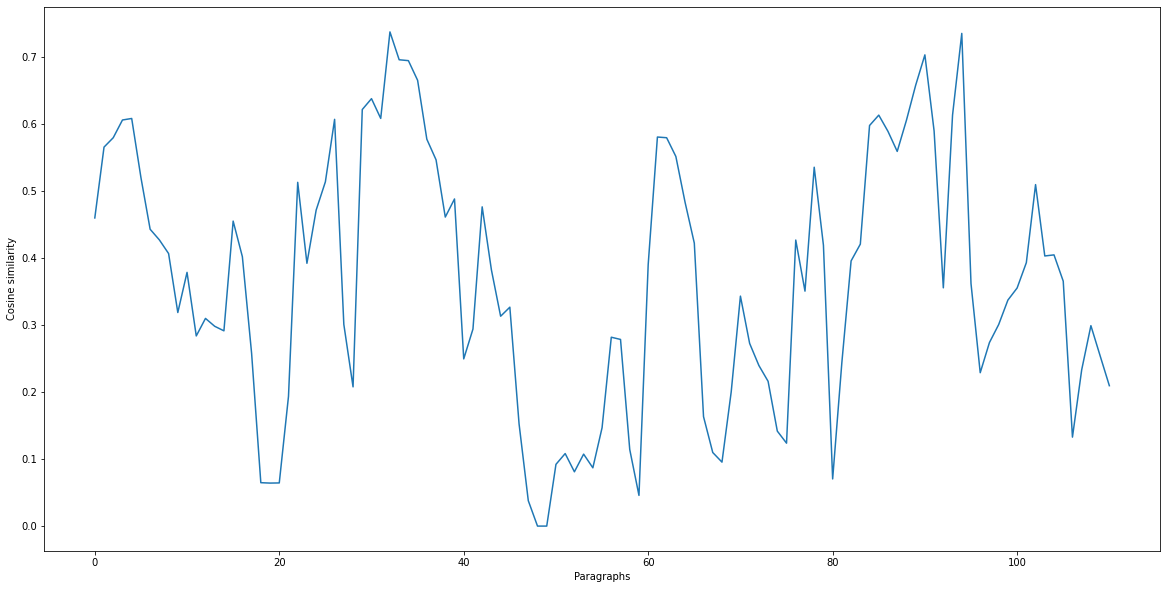

In [59]:
# Plot the cosine similarity
fig = plt.figure(figsize=(20, 10))
plt.plot(cos_sim(n)[0])
plt.xlabel('Paragraphs')
plt.ylabel('Cosine similarity')
plt.show()